## Packages

In [ ]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

## Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Test: taking image out of Dataset

In [ ]:
workspace_path = '/content/drive/MyDrive/Google Colab/Face Mask Detection/'
image_path = workspace_path + 'Dataset/Face_Mask/00000_Mask.jpg'
image_array = cv2.imread(image_path)

**Note**: cv2 return a BGR image

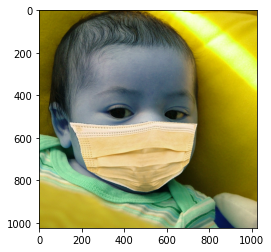

In [ ]:
plt.imshow(image_array)

**Note:** OpenCV - How to convert BGR to RBG

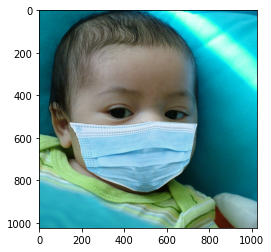

In [ ]:
plt.imshow(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))

* Create path to Dataset
* Identity classes (0: Face_Mask, 1: No_Mask)
* This for-loop can print out all images in Dataset if remove all the `break`

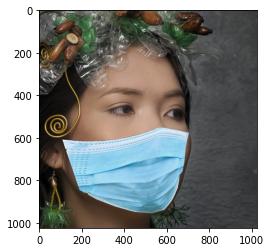

In [ ]:
data_directory = workspace_path + "Dataset/"
classes = ['Face_Mask', 'No_Mask']
for category in classes:
    path = os.path.join(data_directory, category)
    for image in os.listdir(path):
        image_array = cv2.imread(os.path.join(path, image))
        plt.imshow(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

Resize image to 224x224 because that the size of MobileNet input image

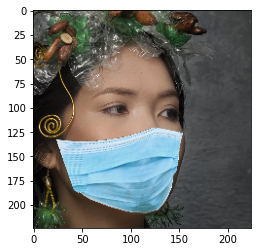

In [ ]:
image_size = (224, 224)
new_array = cv2.resize(image_array, image_size)
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

## Reading the images and coverting all to array

Put all images in Dataset into `training_data`

**Note:** element of `training_data` is (X, y)

In [ ]:
training_data = []
def create_training_data():
    for category in classes:
        path = os.path.join(data_directory, category)
        class_number = classes.index(category)
        for image in os.listdir(path):
            try:
                image_array = cv2.imread(os.path.join(path, image))
                new_array = cv2.resize(image_array, image_size)
                training_data.append([new_array, class_number])
            except Exception as ex:
                print(ex)

In [ ]:
create_training_data()

In [ ]:
len(training_data)

1950

Shuffle `training_data`

In [ ]:
import random
random.shuffle(training_data)

Split `training_data` into `X` and `y`

In [ ]:
X = []
y = []

for feature, label in training_data:
    X.append(feature)
    y.append(label)
    
X = np.array(X).reshape(-1, image_size[0], image_size[1], 3)

In [ ]:
X.shape

(1950, 224, 224, 3)

Normalize input X (this is just the **beginner** way of doing this)

In [ ]:
X = X / 255.0

In [ ]:
y = np.array(y)

In [ ]:
y.shape

(1950,)

## Save and Load X and y

In [ ]:
import pickle

In [ ]:
pickle_out = open('X.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open('y.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open('X.pickle', 'rb')
X = pickle.load(pickle_in)

pickle_in = open('y.pickle', 'rb')
y = pickle.load(pickle_in)

## Deep Learning Model for Training - Transfer Learning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Download MobileNet

In [ ]:
model = tf.keras.applications.mobilenet.MobileNet()

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

## Transfer Learning - Tuning, weights will start from last check point

Get the **input** of the first layer and **output** of the last layer which we want to keep

We are going to replace the last 3 layers of model

In [ ]:
base_input = model.layers[0].input
base_output = model.layers[-4].output

In [ ]:
flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(flat_layer)
final_output = layers.Activation('sigmoid')(final_output)

How to create a new model

In [ ]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

## Setting for binary classification

Define loss-funtion, optimizer, metrics of new_model

In [ ]:
new_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Freeze model's weights except for 2 final layers that we put in

In [ ]:
for layer in model.layers[0: -3]:
    layer.trainable = False

Train model, do note that you can use `history = new_model.fit(...)` for later use (like plot accuracy and loss)

In [ ]:
new_model.fit(X, y , epochs = 10, validation_split = 0.1)

Epoch 1/10
55/55 [==============================] - 26s 216ms/step - loss: 0.0233 - accuracy: 0.9880 - val_loss: 6.7757e-09 - val_accuracy: 1.0000
Epoch 2/10
55/55 [==============================] - 10s 186ms/step - loss: 3.1133e-05 - accuracy: 1.0000 - val_loss: 1.1152e-09 - val_accuracy: 1.0000
Epoch 3/10
55/55 [==============================] - 10s 189ms/step - loss: 2.1908e-05 - accuracy: 1.0000 - val_loss: 7.3830e-10 - val_accuracy: 1.0000
Epoch 4/10
55/55 [==============================] - 11s 192ms/step - loss: 4.0219e-06 - accuracy: 1.0000 - val_loss: 1.3512e-09 - val_accuracy: 1.0000
Epoch 5/10
55/55 [==============================] - 11s 192ms/step - loss: 2.5108e-04 - accuracy: 1.0000 - val_loss: 8.8026e-06 - val_accuracy: 1.0000
Epoch 6/10
55/55 [==============================] - 11s 193ms/step - loss: 0.0486 - accuracy: 0.9937 - val_loss: 3.1435 - val_accuracy: 0.7641
Epoch 7/10
55/55 [==============================] - 11s 193ms/step - loss: 0.0067 - accuracy: 0.9983 - val

Save and Load model

In [ ]:
new_model.save('my_model.h5')

In [ ]:
new_model = tf.keras.models.load_model('my_model.h5')

## Checking the network for predictions

In [ ]:
image_array = cv2.imread(workspace_path + "Dataset/Face_Mask/00002_Mask.jpg")

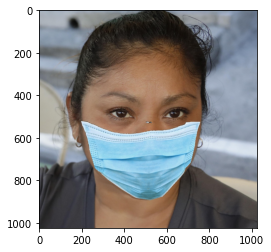

In [ ]:
plt.imshow(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))

In [ ]:
final_image = cv2.resize(image_array, image_size)
final_image = np.expand_dims(final_image, axis = 0)
final_image = final_image / 255.0

In [ ]:
predict = new_model.predict(final_image)

The value of `predict` is near 0, smaller than 0.5 (this will be our threshold) so that mean our model predict that this image is Face_Mask (which is correct)

In [ ]:
predict

array([[2.3193263e-10]], dtype=float32)

## Checking the network for unknown image

In [ ]:
unknown_image = cv2.imread(workspace_path + 'Dataset/sad_woman_face.jpg')

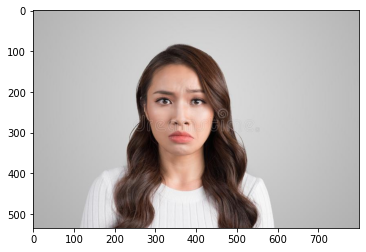

In [ ]:
plt.imshow(cv2.cvtColor(unknown_image, cv2.COLOR_RGB2BGR))

## This is how we crop the face of the image for our model to predict 

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
gray = cv2.cvtColor(unknown_image, cv2.COLOR_BGR2GRAY)

In [ ]:
gray.shape

(534, 800)

In [ ]:
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
for x, y, w, h in faces:
  roi_gray = gray[y:y+h, x:x+w]
  roi_color = unknown_image[y:y+h, x:x+w]
  cv2.rectangle(unknown_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
  facess = face_cascade.detectMultiScale(roi_gray)
  if len(facess) == 0:
    print('Face not detected')
  else:
    for(ex, ey, ew, eh) in facess:
      face_roi = roi_color[ey:ey+eh, ex:ex+ew]

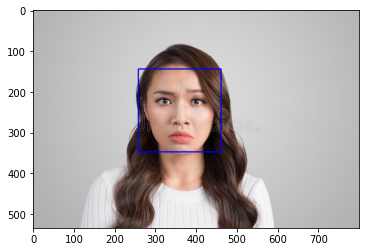

In [ ]:
plt.imshow(cv2.cvtColor(unknown_image, cv2.COLOR_RGB2BGR))

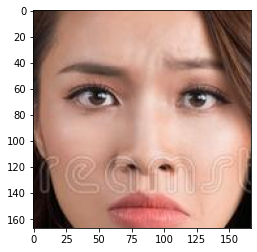

In [ ]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_RGB2BGR))

In [ ]:
final_image = cv2.resize(face_roi, image_size)
final_image = np.expand_dims(final_image, axis = 0)
final_image = final_image / 255.0

In [ ]:
predict = new_model.predict(final_image)

In [ ]:
predict

array([[1.]], dtype=float32)